https://www.kaggle.com/competitions/playground-series-s3e2/discussion


https://www.kaggle.com/competitions/playground-series-s3e1/discussion

In [1]:
DATA_DIR='playground-series-s3e2/'

In [61]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import datetime

In [6]:
df=pd.read_csv(DATA_DIR+"/train.csv").iloc[:,1:] #drop ID

In [113]:
def prepareDataset(df, datasetParams, skipY=False): #prepare dataset, using customization parameters
    df_updated=df.copy()
    if "drop" in datasetParams:
        df_updated = df_updated.drop(df_updated.columns[datasetParams["drop"]], axis = 1)
    if skipY:
        return df_updated.values
    else:
        return (df_updated.iloc[:,:-1].values, df_updated.iloc[:,-1:].values)

In [96]:
#catboost training functions
from catboost import CatBoostClassifier, Pool, cv

def catBoostTrain(X,Y,X_test,trainingParams):
    params=trainingParams.copy()
    if not "st_weight" in params:
        params["st_weight"]=1
    cat = CatBoostClassifier(class_weights={0:1,1:params["st_weight"]})
    cat_feats=[] #handle str and other features
    for i in range(X.shape[1]):
        if type(X[0,i])==str:
            cat_feats.append(i)
    cat.fit(X, Y, cat_features=cat_feats, plot=False, verbose=False) #train
    return cat.predict_proba(X_test)[:,1] #return probabilities of 1


In [97]:
def runTests(df, datasetParams, trainingParams, kfolds=10):
    X, Y = prepareDataset(df, datasetParams) #prepare dataset with all the params
    
    totalRes=0
    AUCs=[]
    stf = StratifiedKFold(kfolds, shuffle=True, random_state=1) #make k-folds
    for train_ix, test_ix in tqdm(stf.split(X, Y), total = kfolds):
        Y_Pred=catBoostTrain(X[train_ix], Y[train_ix], X[test_ix], trainingParams) #run training and get predictions
        auc=roc_auc_score(Y[test_ix], Y_Pred) #calculate AUC
        totalRes+=auc
        AUCs.append(auc)
    plt.hist(AUCs) #hist for AUCs in k-folds
    return totalRes/kfolds

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.12s/it]


0.880936642908914

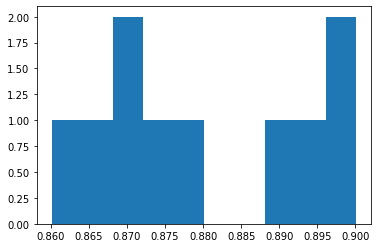

In [98]:
datasetParams={}
trainingParams={}

#datasetParams["drop"]=[0]
datasetParams["st_weight"]=1

runTests(df,datasetParams,trainingParams)

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.13s/it]


0.880936642908914

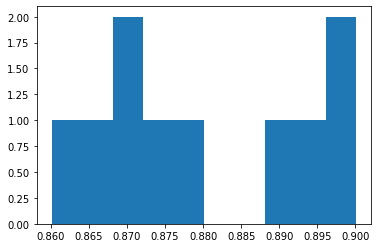

In [99]:
datasetParams["st_weight"]=10

runTests(df,datasetParams,trainingParams)

100%|███████████████████████████████████████████| 10/10 [02:11<00:00, 13.11s/it]


0.880936642908914

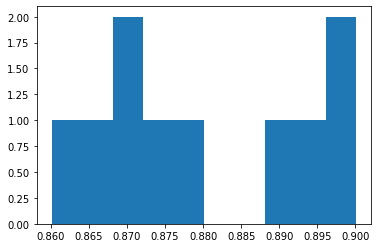

In [100]:
datasetParams["st_weight"]=40

runTests(df,datasetParams,trainingParams)

100%|███████████████████████████████████████████| 10/10 [02:33<00:00, 15.32s/it]


0.880936642908914

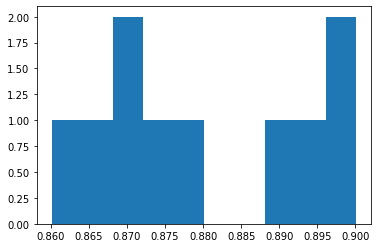

In [101]:
datasetParams["st_weight"]=100

runTests(df,datasetParams,trainingParams)

100%|███████████████████████████████████████████| 10/10 [02:40<00:00, 16.04s/it]


0.880936642908914

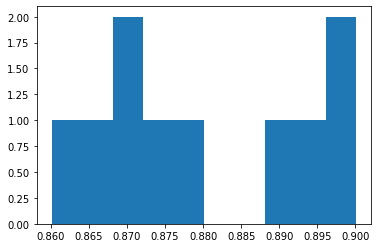

In [102]:
datasetParams["st_weight"]=400

runTests(df,datasetParams,trainingParams)

100%|███████████████████████████████████████████| 10/10 [02:38<00:00, 15.90s/it]


0.880936642908914

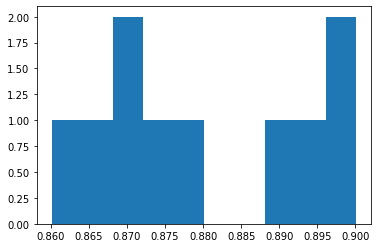

In [103]:
datasetParams["st_weight"]=1000

runTests(df,datasetParams,trainingParams)

In [104]:
datasetParams["st_weight"]=3000

runTests(df,datasetParams,trainingParams)

  0%|                                                    | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [118]:
#Submission file craft


#datasetParams={}
#trainingParams={}

dfTest=pd.read_csv(DATA_DIR+"/test.csv")
ids=dfTest.iloc[:,0]
dfTest=dfTest.iloc[:,1:] #drop ID
X, Y = prepareDataset(df, datasetParams)
X_test = prepareDataset(dfTest, datasetParams, skipY=True)

Y_Pred = catBoostTrain(X, Y, X_test, trainingParams)
dfSub=pd.DataFrame({"stroke":Y_Pred},index=ids)
dfSub.to_csv(DATA_DIR+'/Subs/sub_'+datetime.datetime.now().strftime("%d.%m.%Y__%H.%M.%S")+'.csv')
dfSub.head(12)

,stroke
id,
15304,0.037306
15305,0.166087
15306,0.000530
15307,0.478162
15308,0.008227
